In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from os.path import join
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted
from tqdm import tqdm
from sklearn.manifold import TSNE

import torch
from torchvision.io import read_image
import torchvision.models as models

In [3]:
from experiment_utils import set_env
set_env()

In [4]:
from cgn_framework.mnists.dataloader import get_tensor_dataloaders
from mnists.models.classifier import CNN

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [7]:
data_root = "../cgn_framework/mnists/data/"
dataset = "colored_MNIST"

### Load dataloaders

In [8]:
dl_og, _ = get_tensor_dataloaders(dataset=f"{dataset}")
dl_cf, _ = get_tensor_dataloaders(dataset=f"{dataset}_counterfactual")

### Extract `ResNet18` features

In [9]:
# model_type = "resnet18"
model_type = "cnn_trained_on_cf_dataset"

In [10]:
if model_type == "resnet18":
    model = models.resnet18(pretrained=True)
    model.fc = torch.nn.Identity()
elif model_type == "cnn_trained_on_cf_dataset":
    ckpt_path = f"../cgn_framework/mnists/experiments/classifier_{dataset}_counterfactual/weights/ckp_epoch_10.pth"
    model = CNN()
    model.load_state_dict(torch.load(ckpt_path, map_location="cpu"))
    model.cls = torch.nn.Identity()
else:
    raise ValueError(f"Could not identify model type {model_type}")

In [11]:
model = model.eval()

In [12]:
def get_model_features(model, dl, num_batches_to_use=None):
    iterator = tqdm(
        dl,
        desc="Extracting features",
        bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}',
    )
    fvecs = []
    labels = []
    ctr = 0
    for (data, label) in iterator:
        fvec = model(data)
        fvecs.append(fvec)
        labels.append(label)
        
        if ctr == num_batches_to_use:
            break
        
        ctr += 1

    fvecs = torch.cat(fvecs, dim=0)
    labels = torch.cat(labels, dim=0)
    return fvecs, labels

In [13]:
features_og, y_og = get_model_features(model, dl_og, num_batches_to_use=20)

Extracting features:   2%|▏         | 20/938 [00:02<02:02,  7.47it/s]                                                  


In [14]:
features_cf, y_cf = get_model_features(model, dl_cf, num_batches_to_use=20)

Extracting features:   3%|▎         | 20/782 [00:02<01:48,  7.02it/s]                                                  


In [15]:
features_og.shape, features_cf.shape, y_og.shape, y_cf.shape

(torch.Size([1344, 64]),
 torch.Size([1344, 64]),
 torch.Size([1344]),
 torch.Size([1344]))

### Visualize TSNE

In [16]:
def reduce_dimensionality(X, dim=2):
    assert len(X.shape) == 2
    N, D = X.shape
    assert D >= dim
    
    if isinstance(X, torch.Tensor):
        X = X.detach().cpu().numpy()

    tsne = TSNE(n_components=dim)
    Z = tsne.fit_transform(X)
    return Z

In [17]:
Z_og = reduce_dimensionality(features_og)

/home/lcur0478/.conda/envs/gcn-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lcur0478/.conda/envs/gcn-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [18]:
Z_cf = reduce_dimensionality(features_cf)

/home/lcur0478/.conda/envs/gcn-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lcur0478/.conda/envs/gcn-gpu/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [19]:
Z_og.shape, Z_cf.shape

((1344, 2), (1344, 2))

### Visualize scatter plot

In [20]:
def create_df(Z, y):
    df = pd.DataFrame(None)
    df["Z1"] = Z[:, 0]
    df["Z2"] = Z[:, 1]
    df["y"] = y
    return df

In [21]:
df_og = create_df(Z_og, y_og)
df_cf = create_df(Z_cf, y_cf)

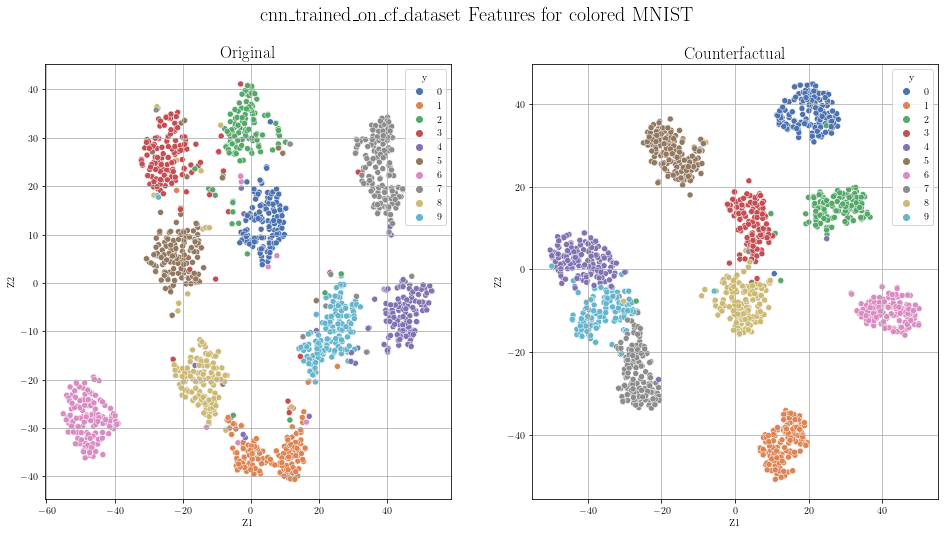

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].grid()
ax[0].set_title("Original", fontsize=17)
sns.scatterplot(data=df_og, x="Z1", y="Z2", hue="y", palette="deep", ax=ax[0])

ax[1].grid()
ax[1].set_title("Counterfactual", fontsize=17)
sns.scatterplot(data=df_cf, x="Z1", y="Z2", hue="y", palette="deep", ax=ax[1])

plt.suptitle(f"{model_type} Features for {dataset.replace('_', ' ')}", fontsize=20)
plt.show()